In [4]:
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import glob
%matplotlib inline


#import seaborn as sns
#sns.set(rc={"figure.figsize": (8, 8)})

In [35]:
#import matplotlib.pyplot as plt
home = os.getenv('HOME') #Ilan's home directory
plumes = os.getenv('PLUMES') #plumes data
cuip = os.getenv('CUIP')
csvs = 'output_csvs'


In [36]:
# %load label_copy.py
import scipy as sp
from scipy import ndimage
import pylab as pl
from skimage import filters


PLOT = False


def rebin(arr, new_shape):
    """Rebin 2D array arr to shape new_shape by averaging."""
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)

def getregion(img):

    tmp2 = rebin(img, (img.shape[0]/4, img.shape[1]/4))

    imgtmp = tmp2.copy()
    imgtmp[tmp2<np.mean(tmp2) + 3.*np.std(tmp2)]=0
    imgtmp[imgtmp>0]=1
    

    labels, n_features = ndimage.measurements.label(imgtmp)
    labelsize = np.array([(labels==i).sum() for i in range(labels.max()+1)])

    labs = np.unique(labelsize)
    labdiff = np.diff(np.unique(labelsize))
    
    l= [len(labs),np.max(labdiff[:-1]),(labdiff>=50).sum(),n_features,np.mean(labdiff[:-1]),np.max(labdiff)]
    #print l
    return l

    
if __name__ == '__main__':
    plot = PLOT
    plumes = os.getenv('PLUMES_DATA')
    imgpath = os.path.join(plumes,'outputs/tmp_0*_median.npy')
    tmp = np.sort(glob.glob(imgpath))
    csvfile = open('output_csvs/test.csv','w')
    writer = csv.writer(csvfile,delimiter=',',lineterminator='\n')
    for t in tmp:
        
        try:
            img = np.load(t)[200:1300,:,:].mean(-1)
        except:
            pass
            
        writer.writerow([t[68:], getregion(img))
    csvfile.close()
            



AttributeError: 'NoneType' object has no attribute 'endswith'

In [9]:
# %load read_and_roll.py
import scipy as sp
import numpy as np
import pandas as pd
from scipy import ndimage, signal
import matplotlib.pyplot as plt
#import seaborn as sns
import sys
#sns.set()



def read_and_plot(file_path, plot = False):
    """
    Take csv, clean it and plot all its features as subplots.
    Input is a data frame
    Return a Pandas Dataframe and the plot with plumes highlighted
    As default, no plot is generated, only the dataframe is returned
    """
    col_names = ['image', 'n_patches','2nd_largest_patch','patch_50+_pix','n_features','mean_patch_size', 'largest_patch']
    df = pd.read_csv(file_path, header = None, names=col_names)
    df.loc[:,'image'] = np.array([int(l[12:16].strip().split()[0]) for l in df.loc[:,'image']])
    df.index = df.image
    df.drop('image', axis = 1, inplace = True)

    if plot:
        ax = df.plot(subplots = True,figsize = (8,8), title = str(data_csv))
        df.iloc[135:155,:].plot(subplots = True, ax = ax, color = 'k', legend = False)
        plt.savefig(str.join(data_csv,'.pdf'))
        plt.show()
    
    return df

def roll_and_plot(data_column, window = 100, plot = False, table = False):
    """
    Calculate and plot the rolling mean and rolling standard deviation for given dataframe.
    Input for column and datafile should be a string object.
    Return: Rolling mean and std table and plot saved as a pdf
    Default value for the window is 100.
    Plot is returned as default.
    Set table=True to get the rolling data frame
    """
    
    unsmooth = data_column

    smooth = unsmooth.rolling(window = window, center = True, axis = 0).mean()
    smooth_sd = unsmooth.rolling(window = window, center = True, axis = 0).std()
    final = pd.DataFrame({'unsmooth':unsmooth, 'smooth':smooth, 'smooth_std':smooth_sd})
    
    if plot:
        ax = final.unsmooth.plot(figsize = (8,8), linestyle = 'none', marker = '.')
        final.unsmooth[135:155].plot(ax = ax, marker = '.', linestyle = 'none', c = 'y')
        
        final[['smooth', 'smooth_std']].plot(ax = ax)
        
        plt.title(str(' Rolling window' + window + 'images'), size = 15)
        plt.legend(['Images', 'Mean','St Dev', 'Plumes'], loc = 2)
        plt.ylabel(str(data_column.name + ' (Pixels)'), size = 13)
        plt.xlabel('Image', size = 13)
        plt.show()
        plt.savefig(str(data_column.name + '_roll.pdf'))
    
    if table:  
        return final
    









#if __name__ == '__main__':
    
#    df = read_and_plot(sys.argv[1], plot = False)
#    column = df[sys.argv[2]]
#    roll_and_plot(column, plot = True)
    
    


# Load the images

Once the images are loaded and saved into a text file they are ready to be plotted using the function read_and:plot as shown below for various cases.

In [ ]:

#imgpath2 =  os.path.join(plumes,'outputs/tmp_01[345][0-9]_mindif.npy')

#print imgpath

#imglist2 = sorted(glob.glob(imgpath2))
        
#print imglist


#empty array to catch read images

    
#imgs_min = np.zeros((nimgs, 1300, 4096))


#for i,f in enumerate(imglist2):
    #print(f)
    #imgs_min[i] = np.load(f)[200:1500,:,:].mean(-1)





#imgpath1 =  os.path.join(plumes,'outputs/tmp_*_median.npy')
#imglist1 = sorted(glob.glob(imgpath1))
#nimgs = len(imglist1)
#imgs = np.zeros((nimgs, 1300, 4096))    
#for i,f in enumerate(imglist1):
    
    #imgs[i] = np.load(f)[200:1500,:,:].mean(-1)
    #writer.writerow([f[68:], getregion(imgs[i])])
     
     
        
        


## The file is loaded here.

A new feature is created, the one you proposed.

In [39]:
df = pd.read_csv('output_csvs/m3sd.csv',header = 0)
df.loc[:,'#image'] = np.array([int(l[12:16].strip().split()[0]) for l in df.loc[:,'#image']])
df.index = df['#image']
del df['#image']


df['patch_size'] = df['mean_patch_size']*df['n_patches']
df.head()

,n_patches,2nd_largest_patch,patch_50+_pix,n_features,mean_patch_size,largest_patch,patch_size
#image,,,,,,,
5,25,4,1,1628,1.304348,278212,32.608696
6,17,3,1,1678,1.200000,278897,20.400000
7,33,14,1,2033,1.580645,276251,52.161290
8,17,30,1,1622,4.133333,278947,70.266667
9,27,24,1,1539,2.240000,278553,60.480000


## Rolling window pandas

This were the first rolling windows which were not correct, this wa sonly the first attempt.

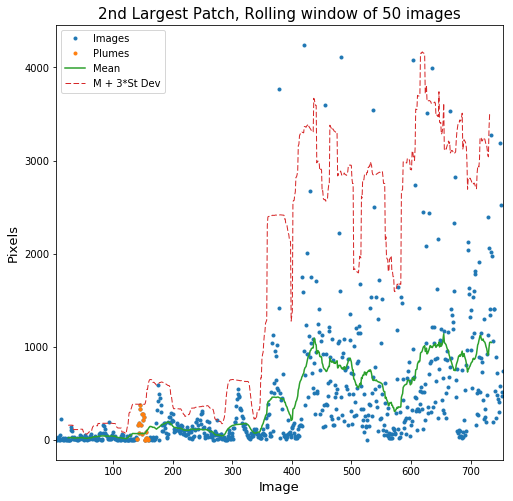

In [41]:
unsmooth = df['2nd_largest_patch'] 

smooth_m = unsmooth.rolling(window = 40, center = True).mean()
smooth_sd = unsmooth.rolling(window = 40, center = True).std()

final = pd.DataFrame({'unsmooth':unsmooth, 'smooth_m':smooth_m, 'smooth_std':smooth_sd})
final['m3sd'] = final.smooth_m + 3*final.smooth_std    

ax = final.unsmooth.plot(figsize = (8,8), linestyle = 'none', marker = '.')
final.unsmooth[135:155].plot(ax = ax, marker = '.', linestyle = 'none')
final['smooth_m'].plot(ax = ax)
final['m3sd'].plot(ax = ax, linestyle ='--', linewidth=1)

plt.title('2nd Largest Patch, Rolling window of 50 images', size = 15)
plt.legend(['Images', 'Plumes', 'Mean','M + 3*St Dev'], loc = 2)
plt.ylabel('Pixels', size = 13)
plt.xlabel('Image', size = 13)

#plt.savefig('output_imgs/m3sd_w50_patchsize_roll.pdf')

## using other smoothing methods

Here is where I used the gaussian filter. The next two results are the same, just using different approaches regarding the index (x-axis). for the first I created a dataframe with all the smoothed and unsmoothed vectors, this was done so I could use the plot method directly from pandas.

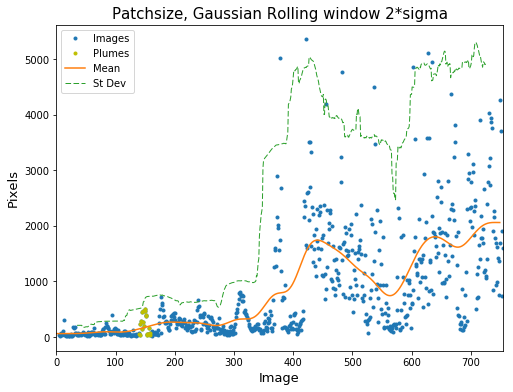

In [42]:
unsmooth = df['patch_size']

smooth_g = unsmooth.rolling(window = 60, center = True, win_type = 'gaussian').mean(std = 30)
g = ndimage.filters.gaussian_filter(unsmooth, sigma = 20)
smooth_sd = unsmooth.rolling(window = 60, center = True).std()

final = pd.DataFrame({'unsmooth':unsmooth, 'smooth_g':smooth_g, 'smooth_std':smooth_sd})
final['g3sd'] = g + 3*final.smooth_std   
final['sg3sd'] = final.smooth_g + 3*final.smooth_std   

ax = final.unsmooth.plot(figsize = (8,6), linestyle = 'none', marker = '.')
final.unsmooth[135:155].plot(ax = ax, marker = '.', linestyle = 'none', c = 'y')
#final.smooth_g.plot()
plt.plot(g)
final['g3sd'].plot(ax = ax, linestyle ='--', linewidth=1)
#final.sg3sd.plot(ax = ax, linestyle = '--', linewidth = 1)

plt.title('Patchsize, Gaussian Rolling window 2*sigma', size = 15)
plt.legend(['Images', 'Plumes', 'Mean','St Dev'], loc = 2)
plt.ylabel('Pixels', size = 13)
plt.xlabel('Image', size = 13)

#plt.savefig('output_imgs/m3sd_w10_2largest_gauss.pdf')


For this second approach I merely used vectors and pylab. I think the plots are the same, just differ in the data types. I will con

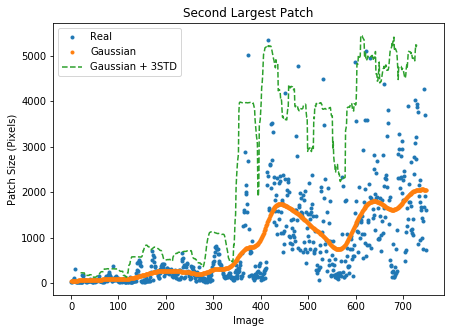

In [43]:
x = np.arange(0,750,1)
plt.figure(figsize = (7,5))
smooth_g = unsmooth.rolling(window = 40, center = True).mean()
g = ndimage.filters.gaussian_filter(unsmooth, sigma = 20)
smooth_sd = unsmooth.rolling(window = 40, center = True).std()
f3sd = smooth_g + 3.*smooth_sd

plt.plot(x, unsmooth, linestyle = 'none', marker = '.')
plt.plot(x, g, linestyle = 'none', marker='.')
plt.plot(x, f3sd, linestyle = '--')
plt.title('Second Largest Patch')
plt.xlabel('Image')
plt.ylabel('Patch Size (Pixels)')
plt.legend(['Real', 'Gaussian', 'Gaussian + 3STD'])



In [ ]:

#tmp2 = rebin(imgs[140], (imgs[139].shape[0]/4, imgs[139].shape[1]/4))

#imgtmp = tmp2.copy()


#imgtmp[tmp2<np.mean(tmp2) + 5.*np.std(tmp2)]=0
#imgtmp[imgtmp>0]=1

#labels, n_features = ndimage.measurements.label(imgtmp)

#labelsize = np.array([(labels==i).sum() for i in range(labels.max()+1)])

#labs = np.unique(labelsize)
#labdiff = np.diff(labs)

#print len(labs),",",np.max(labdiff),',',(labdiff>=50).sum(),',',n_features,',', np.mean(labdiff[:-1])

In [ ]:
def test(n):
    for i in range(n):
        print i,i+1,i-1,2*i
        
#csvfile = open('test.csv', 'wb')
#writer = csv.writer(csvfile)
#writer.writerow([filename, len(filename)])

csvfile = open('output_csvs/test.csv','w')
writer = csv.writer(csvfile,delimiter=',',lineterminator='\n')        
for i,f in enumerate(imglist1):
    
    #print(f)
    imgs[i] = np.load(f)[200:1500,:,:].mean(-1)
    writer.writerow([f[68:], getregion(imgs[i])])
     
csvfile.close()
        
# filter the images based on log-histogram. 

#from skimage import color

#th = 10  #7, 10
#for i in range(nimgs):
    #img_filt[i][img_filt[i] < th] = 0.0
#    imgbw[i] = color.rgb2gray(img_tmp[i]) #set images to grayscale

0 1 -1 0
1 2 0 2
2 3 1 4
3 4 2 6
4 5 3 8
5 6 4 10
6 7 5 12
7 8 6 14
8 9 7 16
9 10 8 18
10 11 9 20
11 12 10 22
12 13 11 24
13 14 12 26
14 15 13 28
15 16 14 30
16 17 15 32
17 18 16 34
18 19 17 36
19 20 18 38
20 21 19 40
21 22 20 42
22 23 21 44
23 24 22 46
24 25 23 48
25 26 24 50
26 27 25 52
27 28 26 54
28 29 27 56
29 30 28 58
30 31 29 60
31 32 30 62
32 33 31 64
33 34 32 66
34 35 33 68
35 36 34 70
36 37 35 72
37 38 36 74
38 39 37 76
39 40 38 78
40 41 39 80
41 42 40 82
42 43 41 84
43 44 42 86
44 45 43 88
45 46 44 90
46 47 45 92
47 48 46 94
48 49 47 96
49 50 48 98
50 51 49 100
51 52 50 102
52 53 51 104
53 54 52 106
54 55 53 108
55 56 54 110
56 57 55 112
57 58 56 114
58 59 57 116
59 60 58 118
60 61 59 120
61 62 60 122
62 63 61 124
63 64 62 126
64 65 63 128
65 66 64 130
66 67 65 132
67 68 66 134
68 69 67 136
69 70 68 138
70 71 69 140
71 72 70 142
72 73 71 144
73 74 72 146
74 75 73 148
75 76 74 150
76 77 75 152
77 78 76 154
78 79 77 156
79 80 78 158
80 81 79 160
81 82 80 162
82 83 81 164
83 84

In [ ]:
#ymd_log = np.log10(y_md)

In [ ]:
#ymd_log[np.isinf(ymd_log)] = 0.0

In [ ]:
#bins_cen = x[:-1] + 0.5*(x[1]-x[0])

In [ ]:
#cols = ['img%d'%(i) for i in range(nimgs)]

#median_data = pd.DataFrame(ymd_log.T, columns = cols)
#median_data.insert(0, 'X', bins_cen)

## Histogram of oriented gradients

Documentation: http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html


In [ ]:

#from skimage.feature import hog

#test, hogimg = hog(imgbw[15], orientations = 10, pixels_per_cell=(16, 16), 
 #                  cells_per_block=(4,4), visualise=True, block_norm='L1')

In [ ]:
#figure(figsize = (12, 10))
#imshow(hogimg, cmap = 'viridis')
#grid(False)

In [ ]:
#imshow(hogimg[580:780, 1800:2200], cmap = 'viridis')
#grid(False)

## Sobel filtering to detect edges of plumes

In [ ]:
from skimage import filters
#edg1 = filters.sobel(imgbw[15])

In [ ]:
#figure(figsize = (12, 10))
#imshow(edg1, cmap = 'viridis')
#grid(False)

In [ ]:
#imshow(edg1[580:780, 1800:2200], cmap = 'viridis')

In [ ]:
#hist(edg1.flatten(), log = True)

In [ ]:
#edges = np.empty_like(imgbw)
#for i in range(nimgs):
#    edges[i] = filters.sobel(imgbw[i])


Making binary images based on filtering the brightness differences.

In [57]:
#label = np.zeros(nimgs)
#imbin = np.empty_like(imgbw)
#imvar = np.zeros(nimgs)
#for i in range(nimgs):
#    imbin[i] = np.where(imgbw[i] > 10, 1.0, 0.0)
#    imvar[i] = imbin[i].sum()
#    if imvar[i] > 1877 and imvar[i] < 40000:
#        label[i] = 1.
    #print i, imvar[i]
    


1 2 3 4 5 5


In [ ]:
#figure(figsize = (12, 12))
#imshow(imbin[141], cmap = 'viridis')
#title('Block Image with plume', size = 14)
#axis('off')
#grid(False)


In [ ]:
#label

In [ ]:
#blk = np.zeros((nimgs, 50, 128))
#lbl = np.zeros(nimgs)
#for k in range(nimgs):
#    for i, x in enumerate(xrange(0,imbin[k].shape[0],26)):
#        for j, y in enumerate(xrange(0,imbin[k].shape[1],32)):
#            view = imbin[k,x:x+26, y:y+32]
#            blk[k,i,j] = np.where(view.sum() > 130, 1., 0.)
#            if blk[k].sum() >= 2. and blk[k].sum() < 30:
#                lbl[k] = 1.

In [ ]:
#t = np.zeros(nimgs/10)
#v = np.empty_like(t)
#for i, j in enumerate(xrange(0, nimgs, 10)):
#    v[i] = imvar[j:j+10].var()
 #   t[i] = i

In [ ]:
#t2 = np.arange(750)
#figure(figsize = (12, 8))
#plot(t2,imvar)
#plot(t2[137:149],imvar[137:149], color = 'r')
#xlabel('Image number', size = 15)
#ylabel('Number of Active Pixels (1s)', size = 15)
#title('Time series of active pixels', size = 18)
#legend(['no plume', 'plume'])

In [ ]:

#figure(figsize = (12, 8))
#plot(t2,np.log10(imvar))
#plot(t2[137:148],np.log10(imvar[137:148]), color = 'r')
#xlabel('Image number', size = 15)
#ylabel('Log10 of Number of Active Pixels (1s)', size = 15)
#title('Time series of active pixels (Log Scale)', size = 18)
#legend(['no plume', 'plume'])

In [ ]:
#figure(figsize = (10,8))
#plot(t,v)
#plot(t[13:16],v[13:16], color = 'r')
#xlabel('Image Group Number', size = 15)
#ylabel('Variance of Number of Active Pixels (1s)', size = 15)
#title('Time series of variance of active pixels', size = 18)
#legend(['no plume', 'plume'])

In [ ]:
#figure(figsize = (10,8))
#plot(t,np.log10(v))
#plot(t[14:16],np.log10(v[14:16]), color = 'r')
#xlabel('Image Group Number', size = 15)
#ylabel('Log of Variance of Number of Active Pixels (1s)', size = 15)
#title('Time series of variance of active pixels (Log scale)', size = 18)
#legend(['no plume', 'plume'])

/gpfs1/cusp/ir729/.conda/envs/JupyterVE/lib/python2.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  from ipykernel import kernelapp as app
/home/cusp/ir729/.conda/envs/JupyterVE/lib/python2.7/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/home/cusp/ir729/.conda/envs/JupyterVE/lib/python2.7/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


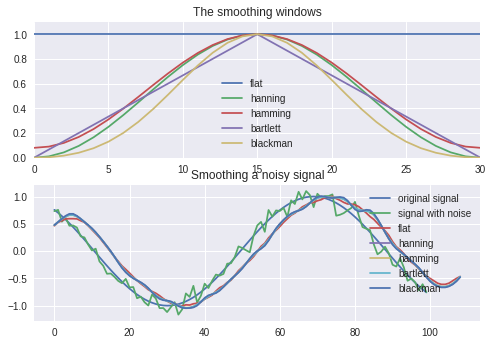

In [1354]:
def smooth_demo():

    t=linspace(-4,4,100)
    x=sin(t)
    xn=x+randn(len(t))*0.1
    y=smooth(x)

    ws=31

    subplot(211)
    plot(ones(ws))

    windows=['flat', 'hanning', 'hamming', 'bartlett', 'blackman']

    hold(True)
    for w in windows[1:]:
        eval('plot('+w+'(ws) )')

    axis([0,30,0,1.1])

    legend(windows)
    title("The smoothing windows")
    subplot(212)
    plot(x)
    plot(xn)
    for w in windows:
        plot(smooth(xn,10,w))
    l=['original signal', 'signal with noise']
    l.extend(windows)

    legend(l)
    title("Smoothing a noisy signal")
    show()

smooth_demo()